In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from skfuzzy import defuzzify

## Problem Statement

* The temperature (T) and humidity (H) are the process variables that are measured.
* These sensor signals are provided to the fuzzy logic controller. 
* The fuzzy logic controller determines the cooling rate (C) that should be generated by the air conditioning unit.
* The objective is to maintain a particular comfort level inside the room


* Temperature level (T): There are two fuzzy states (HG, LW), which denote high and low, respectively, with the corresponding membership functions.
* Humidity level (H): There exist two other fuzzy states (HG, LW) with associated membership functions. 
* The membership functions of T are quite different from those of H, even though the same nomenclature is used.

![prob.png](../images/08/ComfortControl_1.PNG)

![prob.png](../images/08/ComfortControl_nomenclature.PNG)

1. Temperature:
    * HG: S-membership starts at 17 and peaks at 30
    * LW: Z-membership starts decreasing at 15 and reaches 0 at 25

2. Relative Humidity
    * HG: S-membership starts at 0.5 and peaks at 1.0
    * LW: Z-membership starts decreasing at 0.5 and reaches 0 at 1.0
    
3. Cooling Rate
    * PH: SMF 0.1 to 0.8
    * PL: Triangular: -0.2, 0.2, 0.8
    * NH: ZMF -0.1 to -0.8
    * NL: Triangular -0.8, -0.2, 0.2

In [2]:
class FuzzySys():
    def __init__(self):
        self.init_fuzzy()
        self.create_sys()

    def init_fuzzy(self):
        # Antecedent: Input
        # Consequent: Output
        temp_universe = np.arange(-10,40,0.5)
        humid_universe = np.arange(0,1.0, 0.05)
        cool_universe = np.arange(-1.0, 1.0, 0.1)
        
        # New Antecedent/Consequent objects hold universe variables and membership
        # functions
        temperature = ctrl.Antecedent(temp_universe, 'temperature')
        humidity = ctrl.Antecedent(humid_universe, 'humidity')
        cool_rate = ctrl.Consequent(cool_universe, 'cool_rate')


        # Assign membership functions
        # Temperature Membership Functions
        temperature['LW'] = fuzz.zmf(temp_universe, 15, 25)
        temperature['HG'] = fuzz.smf(temp_universe, 17, 30)

        # Humidity membership functions
        humidity['LW'] = fuzz.zmf(humid_universe, 0.5, 1.0)
        humidity['HG'] = fuzz.smf(humid_universe, 0.5, 1.0)

        # Membership function for cooling rate
        cool_rate['PH'] = fuzz.smf(cool_universe, 0.1, 0.8)
        cool_rate['PL'] = fuzz.trimf(cool_universe, [-0.2, 0.2, 0.8])
        cool_rate['NL'] = fuzz.trimf(cool_universe, [-0.8, -0.2, 0.2])
        cool_rate['NH'] = fuzz.zmf(cool_universe, -0.8, -0.1)
        
        self.temperature = temperature
        self.humidity = humidity
        self.cool_rate = cool_rate

    def visualize(self, var_name):
        # Visualize the member functions using the *view()* method
        if var_name == 'temperature':   self.temperature.view()
        elif var_name == 'humidity':    self.humidity.view()
        elif var_name == 'cool_rate':       self.cool_rate.view()

    def setup_rules(self):
        # Fuzzy Rules
        
        rule1 = ctrl.Rule(self.temperature['HG'] & self.humidity['HG'], self.cool_rate['PH'])
        rule2 = ctrl.Rule(self.temperature['HG'] & self.humidity['LW'], self.cool_rate['PL'])
        rule3 = ctrl.Rule(self.temperature['LW'] & self.humidity['HG'], self.cool_rate['NL'])
        rule4 = ctrl.Rule(self.temperature['LW'] & self.humidity['LW'], self.cool_rate['NH'])
        return [rule1, rule2, rule3, rule4]
    
    def create_sys(self):
        # Create Control System (for inferencing)
        self.center_ctrl = ctrl.ControlSystem(self.setup_rules())

        # Create simulation
        self.center_sim = ctrl.ControlSystemSimulation(self.center_ctrl)


    def inference(self, temperature, humidity):
        # Provide inputs to the control simulation 
        self.center_sim.input['temperature'] = temperature
        self.center_sim.input['humidity'] = humidity
        
        # perform computation
        self.center_sim.compute()
        return self.center_sim.output['cool_rate']

The rules defined correspond to the following set of 4 rules:

![rules_1.png](../images/08/Comfort_rules.PNG)

In [3]:
# Creating the fuzzy system
fuzzsys = FuzzySys()

### Defined Membership Functions

**Temperature**

D:\Programs\Anaconda3\envs\ece457b_venv\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


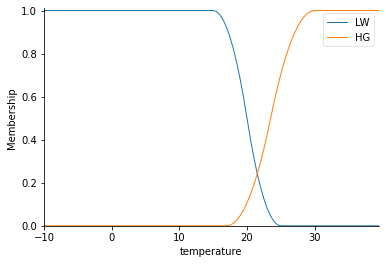

In [4]:
fuzzsys.visualize('temperature')

**Humidity**

D:\Programs\Anaconda3\envs\ece457b_venv\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


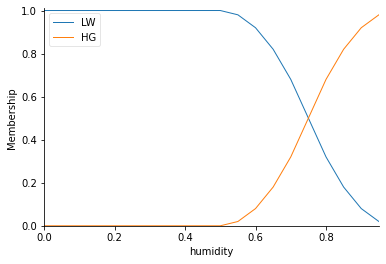

In [5]:
fuzzsys.visualize('humidity')

**Cooling Rate**

D:\Programs\Anaconda3\envs\ece457b_venv\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


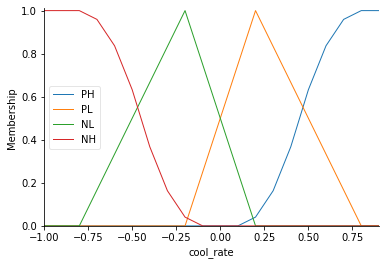

In [6]:
fuzzsys.visualize('cool_rate')

## Inferencing

In [8]:
fuzzsys.inference(0, 0.1)

-0.7049474335188622

Also refer to the documentation [here](https://pythonhosted.org/scikit-fuzzy/) and the [tipping problem](https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_tipping_problem.html)